# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [10]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/bulk_conc_pca_gene_embeddings.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 63)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [12]:
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values.astype("float64")
    y = df["LN_IC50"].values.astype("float64")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    #joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")



🌲 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.2813 0.8524 1.0584 1.096  1.098 ] | Mean: 1.0772 ± 0.1366
  ➤ R²   (folds): [ 0.1134 -0.0295  0.1677 -0.044  -0.1626] | Mean: 0.0090 ± 0.1182

🌲 Drug 3 | Samples: 356
  ➤ RMSE (folds): [1.9811 1.8031 2.0177 2.1131 2.1565] | Mean: 2.0143 ± 0.1231
  ➤ R²   (folds): [-0.0832  0.0439 -0.0051 -0.0628  0.0055] | Mean: -0.0203 ± 0.0464

🌲 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.4634 1.406  1.7803 1.4771 1.3699] | Mean: 1.4993 ± 0.1457
  ➤ R²   (folds): [0.1807 0.2302 0.1923 0.0755 0.0216] | Mean: 0.1401 ± 0.0784

🌲 Drug 6 | Samples: 403
  ➤ RMSE (folds): [1.1439 0.7055 0.9063 0.8654 0.916 ] | Mean: 0.9074 ± 0.1404
  ➤ R²   (folds): [-0.0947  0.072   0.0312 -0.3325 -0.0325] | Mean: -0.0713 ± 0.1423

🌲 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.5018 1.4576 1.4122 1.4336 1.3341] | Mean: 1.4278 ± 0.0555
  ➤ R²   (folds): [ 0.0408  0.0005 -0.051   0.1112  0.1091] | Mean: 0.0421 ± 0.0627

🌲 Drug 11 | Samples: 393
  ➤ RMSE (folds): [1.8193 1.8745 2.05

In [13]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/voom_embeddings_30_pcs_expression_30_pcs.csv", index=False)

print("📁 Saved to rf/results/model_performance_summary.csv")
results_df.head()


📁 Saved to rf/results/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.077223,0.136637,0.009008,0.118176
1,3,356,2.014294,0.123062,-0.020341,0.046434
2,5,394,1.499325,0.145740,0.140072,0.078364
3,6,403,0.907426,0.140383,-0.071318,0.142348
4,9,396,1.427843,0.055519,0.042115,0.062735


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


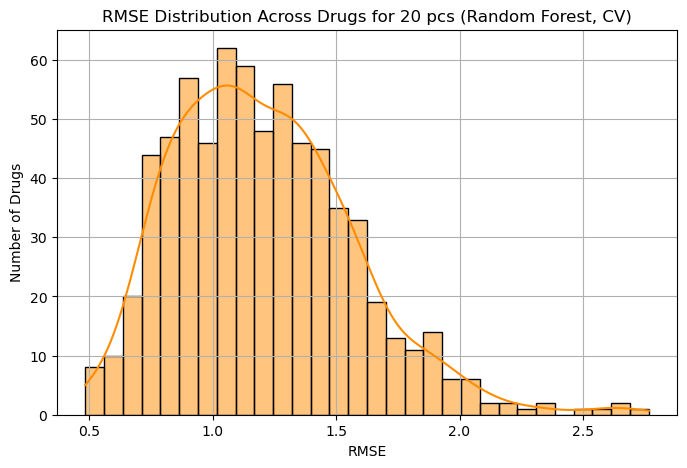

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

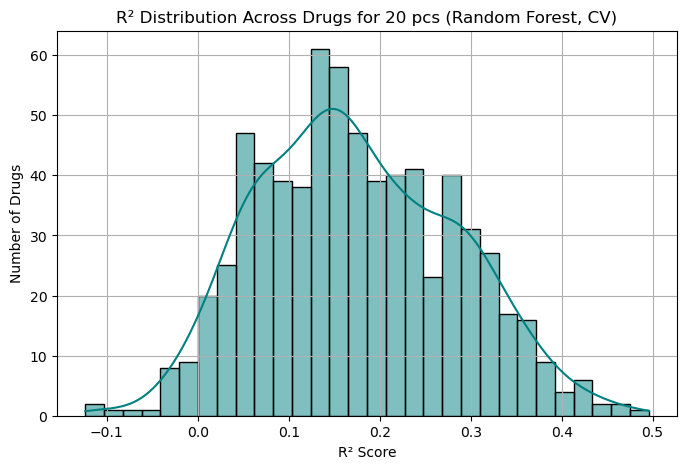

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

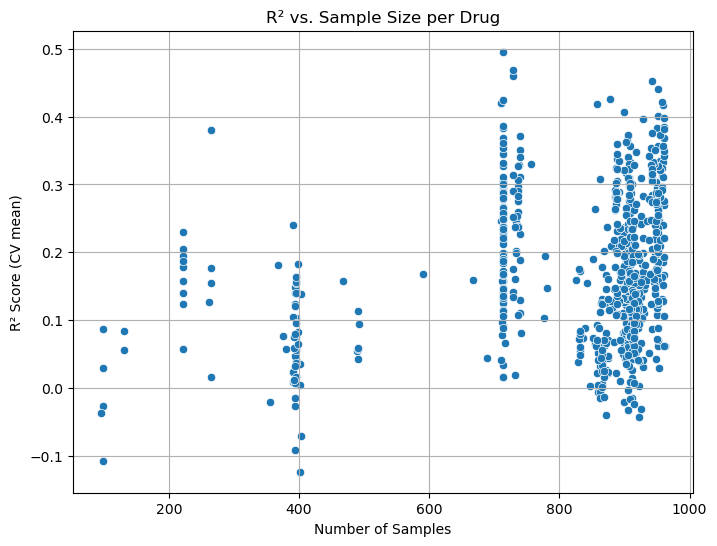

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_mean", data=results_df)
plt.title("R² vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("R² Score (CV mean)")
plt.grid(True)
plt.show()


In [17]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_mean"])
print(f"📊 Pearson r = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

# Spearman (rank-based, robust to non-linearities)
spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_mean"])
print(f"📊 Spearman ρ = {spearman_corr:.3f} (p = {pval_spearman:.3g})")


📊 Pearson r = 0.229 (p = 9.82e-10)
📊 Spearman ρ = 0.210 (p = 2.05e-08)


Text(0.5, 1.0, 'R² vs. IC50 Variance')

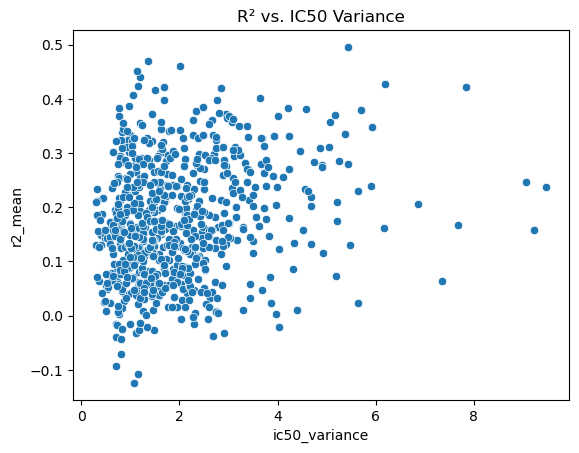

In [18]:
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_mean")
plt.title("R² vs. IC50 Variance")
